# Start
Not using comet.ai or w&b - because they require a sign up
Will use mlflow  - as I already have code for it. 


### Use code from:
https://learn.microsoft.com/en-us/azure/databricks/_extras/notebooks/source/mlflow/mlflow-pytorch-training.html

Note the AI speech recognition code doesn't add much:
https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/

Maybe I just need to add:
device agnostic code
early stopping condition
Other metrics (precision, recall, f1)

Then use the mlflow + tensor board code. 


In [1]:
%run train_func.py

C:\Users\AT030915\AIG\venv\AIG_venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (151) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


input shape: (1,151,801)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 1, 197]           2,266
               GRU-2  [[-1, 1, 1375], [-1, 2, 1375]]               0
            Linear-3              [-1, 1, 1375]       1,892,000
           Sigmoid-4                 [-1, 1375]               0
Total params: 1,894,266
Trainable params: 1,894,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 28.83
Params size (MB): 7.23
Estimated Total Size (MB): 36.51
----------------------------------------------------------------


C:\Users\AT030915\AIG\venv\AIG_venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (151) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1] loss: 0.6411594748497009, learning rate [0.0004], training accuracy cutoff (0.8): 0.9456623792648315, average label 0.05433766171336174
Epoch [2] loss: 0.4759998321533203, learning rate [0.00042291169451073987], training accuracy cutoff (0.8): 0.6273766160011292, average label 0.015480519272387028
Epoch [3] loss: 0.34705406427383423, learning rate [0.0004458233890214797], training accuracy cutoff (0.8): 0.6273766160011292, average label 0.015480519272387028
Epoch [4] loss: 0.7767381072044373, learning rate [0.0004687350835322196], training accuracy cutoff (0.8): 0.6273766160011292, average label 0.015480519272387028


KeyboardInterrupt: 

In [1]:
#to launch the experiments server 

#!mlflow server   


# Load Model + Create weights logger 

In [2]:
import torch
from model import * #need to load in class

model_filepath = 'Saved_models/model_test_mel_100_epochs'
model = torch.load(model_filepath)

model

TriggerWord_LSTM(
  (Conv): Conv1d(151, 1, kernel_size=(15,), stride=(4,))
  (GRU): GRU(197, 1375, num_layers=2, batch_first=True, dropout=0.8)
  (Dense): Linear(in_features=1375, out_features=1375, bias=True)
  (Sigmoid): Sigmoid()
)

In [3]:
def log_weights(model,step):
    '''
    GRU - need to use all weight which returns a (2,4) list of weights
    - biases need to type in bias_hh_l0 (there a 10,01,00,11 - not worth adding to this
    '''
    
    writer.add_summary(histogram('weights/Conv/weight', model.Conv.weight.data).eval(), step)
    writer.add_summary(histogram('weights/Conv/bias'  , model.Conv.bias.data).eval(), step)

    # NO GRU W  + B added 

    writer.add_summary(histogram('weights/Dense/weight', model.Dense.weight.data).eval(), step)
    writer.add_summary(histogram('weights/Dense/weight', model.Dense.weight.data).eval(), step)    


# Modules + hyperparameters set 

In [4]:
import torch
#hyper parameters 
import torch.optim as optim
from model import get_accuracy
from model import *
from data_loading import resize_label
from data_loading import *
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np


# Create Params dictionary

class Params(object):

    def __init__(self, batch_size, test_batch_size, number_frequencies, number_time_steps, epochs, lr, seed, cuda, log_interval,early_stopper_patience,early_stopper_min_delta, label_time,cutoff):
        '''
        Names self explanatory - seed = Random seed number, log_interval - the intervals at which the weights and biases will be recorded 
        '''

        self.batch_size = batch_size

        self.test_batch_size = test_batch_size

        self.epochs = epochs

        self.lr = lr
        
        self.number_frequencies = number_frequencies
        
        self.number_time_steps = number_time_steps
        

        self.seed = seed

        self.cuda = cuda

        self.log_interval = log_interval

        self.early_stopper_patience = early_stopper_patience
        
        self.early_stopper_min_delta = early_stopper_min_delta
        
        self.label_time = label_time
        
        self.cutoff = cutoff

In [5]:
# modules needed from: https://learn.microsoft.com/en-us/azure/databricks/_extras/notebooks/source/mlflow/mlflow-pytorch-training.html
from __future__ import print_function

import os

import tempfile

import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torch.autograd import Variable

from tensorboardX import SummaryWriter

from collections import namedtuple

import tensorflow as tf

import tensorflow.summary

from tensorflow.summary import scalar

from tensorflow.summary import histogram

#from chardet.universaldetector import UniversalDetector

In [22]:
args =Params(batch_size = 4, test_batch_size = 4,
             number_frequencies = 151,
             number_time_steps = 400,
             epochs = 100, lr =0.01, 
             seed = 1, cuda = False, 
             log_interval = 200,
             early_stopper_patience = 3,
             early_stopper_min_delta=0.01,
             label_time = 1375,
            cutoff =0.8) #enter zero then label_time (shape of output of output of nerual network will be equal to the size of the input spectrogram)),

cuda = not args.cuda and torch.cuda.is_available()
device = get_default_device() #not sure if I'm going to use this 
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#  Load data

In [23]:
#### Load data 

test_waveform = ReadData_Mel('test',spectrogram_str=False)
test_data = ReadData_Mel('test',spectrogram_str=True, normalize = True, mask_str = False, number_frequencies = args.number_frequencies,number_time_steps = args.number_time_steps, t_l = 100, f_l = 2)
#ReadData('test',spectrogram_str='True',number_frequencies = spec_freq,number_time_steps = spec_time)
train_data = ReadData_Mel('train',spectrogram_str=True, normalize = True, mask_str = False, number_frequencies = args.number_frequencies,number_time_steps = args.number_time_steps, t_l = 100, f_l = 2)
#ReadData('train',spectrogram_str='True',number_frequencies = spec_freq,number_time_steps = spec_time)

train_loader = DataLoader(train_data, args.batch_size, shuffle=False)
test_loader = DataLoader(test_data, args.batch_size, shuffle=False)






In [24]:
#### Initialise model

# import the model and initialise 
#load in to know the size of the spectrogram - the fft does quite give you a spec_time length for the time dimension
spec_wave = test_data[-1][0]
spec_label = test_data[-1][1]



input_freq =spec_wave.shape[1]
input_time = spec_wave.shape[2]

output_time = args.label_time
if output_time ==0:
    output_time = input_time


hidden_time = output_time #could change this down the line 


model =TriggerWord_LSTM(input_freq, input_time , hidden_time, output_time, Conv_p(),GRU_p())
 
#torch.load('model_test_28_04_23_100_epochs')
#TriggerWord_LSTM(input_freq, input_time , hidden_time, output_time, Conv_p(),GRU_p())
#SimpleRNN(time = input_time,dropout_rate=0.5)

#model.Conv
print(f"input shape: (1,{input_freq},{input_time})")  
summary(model, (input_freq,input_time))     

input shape: (1,151,801)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 1, 197]           2,266
               GRU-2  [[-1, 1, 1375], [-1, 2, 1375]]               0
            Linear-3              [-1, 1, 1375]       1,892,000
           Sigmoid-4                 [-1, 1375]               0
Total params: 1,894,266
Trainable params: 1,894,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 28.83
Params size (MB): 7.23
Estimated Total Size (MB): 36.51
----------------------------------------------------------------


In [25]:
#create early stopper class
#I'll be using training instead of validation loss 
#https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [26]:
#### Choose optimizers,scheduler, loss, and early stopping condtion
criterion = torch.nn.BCELoss()

#alternate optmizer + scheduler - from guidance from https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/
optimizer = optim.AdamW(model.parameters(), args.lr)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
	max_lr=args.lr,
	steps_per_epoch=int(len(train_data)),
	epochs=args.epochs,
	anneal_strategy='linear')

early_stopper = EarlyStopper(patience=args.early_stopper_patience, min_delta=args.early_stopper_min_delta)


# Create main training functions

In [27]:
if cuda:
    model.cuda()

writer = None # Will be used to write TensorBoard events

def log_scalar(name, value, step):

    """Log a scalar value to both MLflow and TensorBoard"""

    #writer.add_summary(scalar(name, value).eval(), step)

    mlflow.log_metric(name, value, step=step)

In [50]:

def train(epoch,N_trainloader):
    running_loss = 0.0
    running_accuracy = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_av_label = 0.0 
    model.train()
    for i, data in enumerate(train_data):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels_og = data
        
        labels =  resize_label(labels_og, args.label_time)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        if early_stopper.early_stop(loss):             
            break
        
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_accuracy += f_acc(outputs,labels)
        #get_accuracy(labels, outputs,cutoff=args.cutoff)
        running_prec += f_prec(outputs,labels)
        running_rec  += f_rec(outputs,labels)
        running_av_label += torch.mean(labels)
        # if i % 4 == 3:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
        #     running_loss = 0.0
    
    lr_end = scheduler.get_last_lr()
    acc = running_accuracy/N_trainloader
    prec = running_prec/N_trainloader
    rec = running_rec/N_trainloader
    
    mean_label = running_av_label/N_trainloader
    
    print(f'Epoch [{epoch + 1}] loss: {loss}, learning rate {lr_end}, training accuracy cutoff ({args.cutoff}): {acc}, average label {mean_label}')
        
    log_scalar('loss',loss,step=epoch)
    log_scalar('lr',lr_end[0],step=epoch)
    log_scalar('accuracy_with_cutoff',acc,step=epoch)
    log_scalar('precision_with_cutoff',prec,step=epoch)
    log_scalar('recall_with_cutoff',rec,step=epoch)    

    log_scalar('mean_label',mean_label,step=epoch)
    
    scheduler.step()



In [51]:
def test(epoch,test_data):
    running_loss = 0.0
    running_accuracy = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_av_label = 0.0 
    
    model.eval()
    
    N_trainloader = len(test_data)


    for i, data in enumerate(test_data):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels_og = data

        labels =  resize_label(labels_og, args.label_time)

        outputs = model(inputs)


        running_accuracy += f_acc(outputs,labels)
        #get_accuracy(labels, outputs,cutoff=args.cutoff)
        running_prec += f_prec(outputs,labels)
        running_rec  += f_rec(outputs,labels)
        running_av_label += torch.mean(labels)

    acc = running_accuracy/N_trainloader
    prec = running_prec/N_trainloader
    rec = running_rec/N_trainloader    
    mean_label = running_av_label/N_trainloader
    print(f'Test for Epoch [{epoch + 1}], accuracy  = {acc}, precision =  {prec}, recall =  {rec}, average label {mean_label}')

    


In [52]:
def main():
    N_trainloader = len(train_data)

    for epoch in range(args.epochs):  # loop over the dataset multiple times
        
        train(epoch,N_trainloader)
        test(epoch,test_data)

    

    
    scheduler.step()    
    

In [53]:
import mlflow.pytorch
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy

#F1 = BinaryF1Score(threshold=args.cutoff)
f_prec = BinaryPrecision(threshold=args.cutoff)
f_rec = BinaryRecall(threshold=args.cutoff)
f_acc = BinaryAccuracy(threshold=args.cutoff)


#choose experiment name
experiment_name = 'test1'
mlflow.set_experiment(experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

with mlflow.start_run() as run:  
    # Log our parameters into mlflow
    for key, value in vars(args).items():
        mlflow.log_param(key, value)
    
    main()
    


Epoch [1] loss: 0.03345305100083351, learning rate [0.0050281622911694515], training accuracy cutoff (0.8): 0.0, average label 0.0
Test for Epoch [1], accuracy  = 0.9454545974731445, precision =  0.0, recall =  0.0, average label 0.05454545095562935
Epoch [2] loss: 0.027715833857655525, learning rate [0.005051073985680192], training accuracy cutoff (0.8): 0.0, average label 0.0
Test for Epoch [2], accuracy  = 0.9454545974731445, precision =  0.0, recall =  0.0, average label 0.05454545095562935
Epoch [3] loss: 0.02552669122815132, learning rate [0.005073985680190932], training accuracy cutoff (0.8): 0.0, average label 0.0
Test for Epoch [3], accuracy  = 0.9454545974731445, precision =  0.0, recall =  0.0, average label 0.05454545095562935
Epoch [4] loss: 0.02394193410873413, learning rate [0.005096897374701671], training accuracy cutoff (0.8): 0.0, average label 0.0
Test for Epoch [4], accuracy  = 0.9454545974731445, precision =  0.0, recall =  0.0, average label 0.05454545095562935
Ep

KeyboardInterrupt: 

In [49]:
def test(epoch,test_data):
    running_loss = 0.0
    running_accuracy = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_av_label = 0.0 
    
    model.eval()
    
    N_trainloader = len(test_data)


    for i, data in enumerate(test_data):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels_og = data

        labels =  resize_label(labels_og, args.label_time)

        outputs = model(inputs)


        running_accuracy += f_acc(outputs,labels)
        #get_accuracy(labels, outputs,cutoff=args.cutoff)
        running_prec += f_prec(outputs,labels)
        running_rec  += f_rec(outputs,labels)
        running_av_label += torch.mean(labels)

    acc = running_accuracy/N_trainloader
    prec = running_prec/N_trainloader
    rec = running_rec/N_trainloader    
    mean_label = running_av_label/N_trainloader
    print(f'Test for Epoch [{epoch + 1}], accuracy  = {acc}, precision =  {prec}, recall =  {rec}, average label {mean_label}')

    


NameError: name 'epoch' is not defined

1.0
tensor(1.)


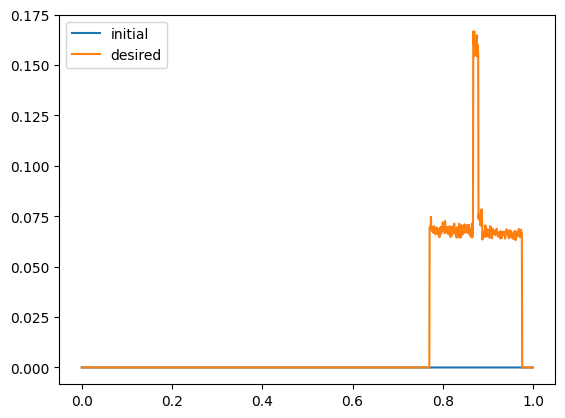

1.0
tensor(1.)


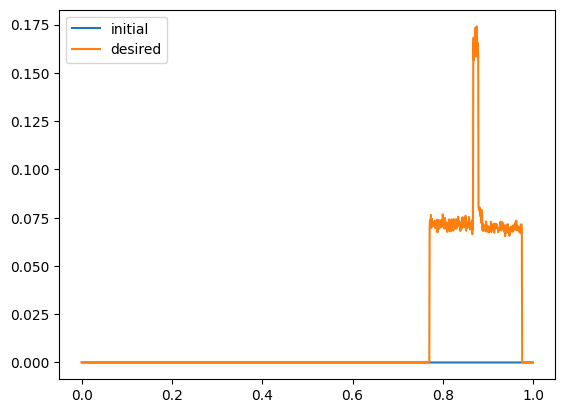

1.0
tensor(1.)


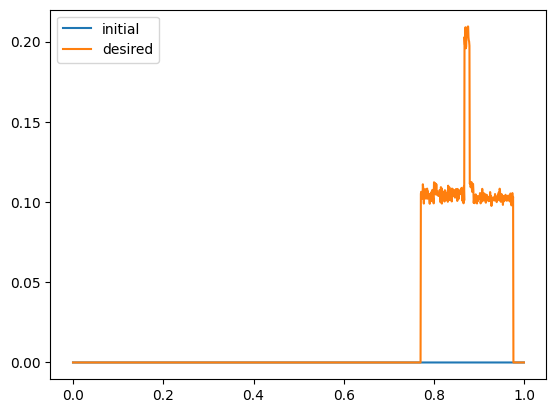

0.8909090909090909
tensor(0.8909)


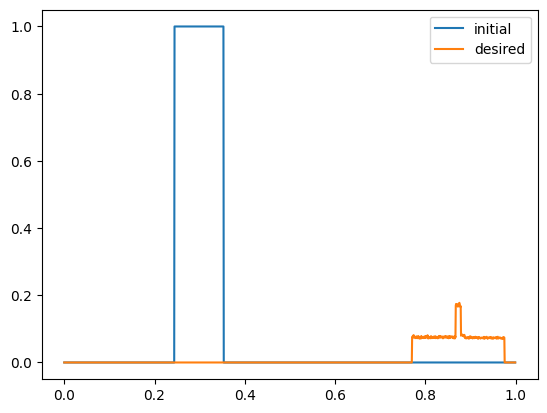

0.8909090909090909
tensor(0.8909)


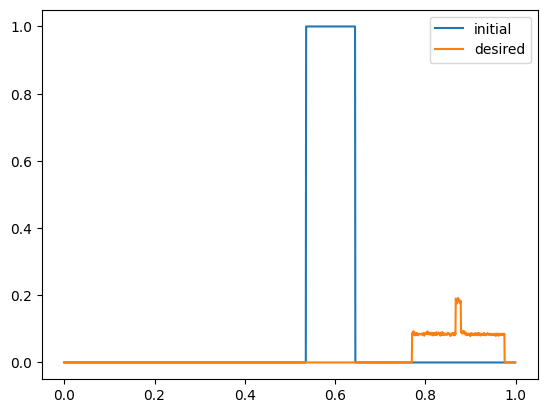

0.8909090909090909
tensor(0.8909)


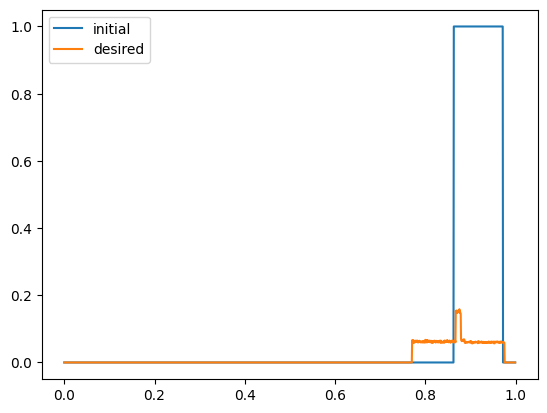

In [40]:
# test on test data

model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_av_label = 0.0 

for i, data in enumerate(train_data):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels_og = data

    labels =  resize_label(labels_og, args.label_time)
    
    out = model(inputs)
    
    print(get_accuracy(labels, out,cutoff=args.cutoff))
    print(f_acc(out,labels))
    
    #plot 
    plot_new_vs_old_label(labels,out.detach().numpy())

In [162]:
%run train

input shape: (1,151,801)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 1, 197]           2,266
               GRU-2  [[-1, 1, 1375], [-1, 2, 1375]]               0
            Linear-3              [-1, 1, 1375]       1,892,000
           Sigmoid-4                 [-1, 1375]               0
Total params: 1,894,266
Trainable params: 1,894,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 28.83
Params size (MB): 7.23
Estimated Total Size (MB): 36.51
----------------------------------------------------------------
Epoch [1] loss: 0.6483827233314514, learning rate [0.0004], training accuracy cutoff (0.1): 0.054337662337662344, average label 0.05433766171336174
Epoch [2] loss: 0.44301438331604004, learning rate [0.00042291169451073987], training accuracy cutoff (0.1): 0.054

KeyboardInterrupt: 

In [43]:
def train(epoch):
    '''
    # The example doesn't pass model and criterion as variables - I assume this is to keep their scope global 
    '''
    N_trainloader = len(train_loader)
    model.train()
    
    running_loss = 0.0
    running_accuracy = 0.0
    running_av_label = 0.0 
    for batch_idx, (data, labels_og) in enumerate(train_loader):
        #resize the labels to match the size of the output of the NN
        labels =  resize_label(labels_og, output_time)
        
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        #add in early stopping 
        
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_accuracy += get_accuracy(labels, outputs,cutoff=cutoff)
        running_av_label += torch.mean(labels)
        if batch_idx % args.log_interval == 0:

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(

                epoch, batch_idx * len(data), len(train_loader.dataset),

                100. * batch_idx / len(train_loader), loss.data.item()))

            step = epoch * len(train_loader) + batch_idx

            log_scalar('train_loss', loss.data.item(), step)

            model.log_weights(step)
    
    print(f'Epoch [{epoch + 1}] loss: {loss}, learning rate {scheduler.get_lr()}, training accuracy cutoff ({cutoff}): {running_accuracy/N_trainloader}, average label {running_av_label/N_trainloader}')

        
    

In [77]:
import mlflow

In [79]:
'''
# The example doesn't pass model and criterion as variables - I assume this is to keep their scope global 
'''
train = ReadData_Mel('train',spectrogram_str=True, normalize = True, mask_str = False, number_frequencies = args.number_frequencies,number_time_steps = args.number_time_steps, t_l = 100, f_l = 2)

N_trainloader = len(train)
model.train()
epoch = 0

running_loss = 0.0
running_accuracy = 0.0
running_av_label = 0.0 
for batch_idx, (data, labels_og) in enumerate(train):
    #resize the labels to match the size of the output of the NN
    labels =  resize_label(labels_og, output_time)


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()

    #add in early stopping 


    optimizer.step()

    # print statistics
    running_loss += loss.item()
    running_accuracy += get_accuracy(labels, outputs,cutoff=args.cutoff)
    running_av_label += torch.mean(labels)
    if batch_idx % args.log_interval == 0:

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(

            epoch, batch_idx * len(data), len(train_loader.dataset),

            100. * batch_idx / len(train_loader), loss.data.item()))

        step = epoch * len(train_loader) + batch_idx

        log_scalar('train_loss', loss.data.item(), step)

        #model.log_weights(step)

print(f'Epoch [{epoch + 1}] loss: {loss}, learning rate {scheduler.get_lr()}, training accuracy cutoff ({args.cutoff}): {running_accuracy/N_trainloader}, average label {running_av_label/N_trainloader}')

Train Epoch: 0 [0/14 (0%)]	Loss: 0.107134
Epoch [1] loss: 0.5574777126312256, learning rate [0.0004], training accuracy cutoff (0.8): 0.9456623376623376, average label 0.05433766171336174


In [74]:
dir(writer)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_closed',
 '_init_op',
 '_resource',
 '_resource_deleter',
 '_set_up_resource_deleter',
 '_tf_api_names',
 '_tf_api_names_v1',
 'as_default',
 'close',
 'flush',
 'init',
 'set_as_default']

In [40]:
writer.add_summary(scalar(name, value).eval(), step)

0

In [96]:
trainloader = train
N_trainloader = len(train_loader)

for epoch in range(args.epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    running_av_label = 0.0 
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels_og = data
        
        labels =  resize_label(labels_og, args.label_time)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_accuracy += get_accuracy(labels, outputs,cutoff=cutoff)
        running_av_label += torch.mean(labels)
        # if i % 4 == 3:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
        #     running_loss = 0.0
    
    
    print(f'Epoch [{epoch + 1}] loss: {loss}, learning rate {scheduler.get_lr()}, training accuracy cutoff ({cutoff}): {running_accuracy/N_trainloader}, average label {running_av_label/N_trainloader}')
    
    

print('Finished Training')


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [4, 1, 151, 801]

In [ ]:
def main():
    
    
    
    train(epoch)
    test(epoc)
    scheduler.step()

In [1]:
%run train

C:\Users\AT030915\AIG\venv\AIG_venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (151) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


input shape: (1,151,801)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 1, 197]           2,266
               GRU-2  [[-1, 1, 1375], [-1, 2, 1375]]               0
            Linear-3              [-1, 1, 1375]       1,892,000
           Sigmoid-4                 [-1, 1375]               0
Total params: 1,894,266
Trainable params: 1,894,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 28.83
Params size (MB): 7.23
Estimated Total Size (MB): 36.51
----------------------------------------------------------------


C:\Users\AT030915\AIG\venv\AIG_venv\lib\site-packages\torch\optim\lr_scheduler.py:1699: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [1] loss: 0.6478915810585022, learning rate [0.0004], training accuracy cutoff (0.1): 0.054337662337662344, average label 0.05433766171336174
Epoch [2] loss: 0.435183048248291, learning rate [0.00042291169451073987], training accuracy cutoff (0.1): 0.054337662337662344, average label 0.05433766171336174


KeyboardInterrupt: 

In [8]:
labels_og.shape

torch.Size([1, 160000])